In [ ]:
!pip install transformers
!pip install torch
!pip install datasets
!pip install evaluate
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install sklearn

In [ ]:
import torch
import evaluate
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, load_metric

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/sample_amazon_product_review_data_20240627_152732.parquet"

In [ ]:
dataset = load_dataset("parquet", data_files={"train": dataset_path})
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['asin', 'helpful_vote', 'parent_asin', 'rating', 'text', 'timestamp', 'title', 'user_id', 'verified_purchase', 'category', 'has_image'],
        num_rows: 952804
    })
})

In [ ]:
def add_sentiment(example):
    rating = example['rating']
    if rating <= 2:
        sentiment = 0  # label for 'negative'
    elif rating == 3:
        sentiment = 1   # label for 'neutral'
    else:
        sentiment = 2   # label for 'positive'
    return {'labels': sentiment}

dataset_with_sentiment = dataset['train'].map(add_sentiment)

Map:   0%|          | 0/952804 [00:00<?, ? examples/s]

In [ ]:
# Split the dataset into train and test
train_test_dataset = dataset_with_sentiment.train_test_split(test_size=0.2)  # 80% train, 20% test

# Access the splits
train_dataset = train_test_dataset['train']
test_dataset = train_test_dataset['test']

In [ ]:
print(train_dataset)
print(train_dataset.features)

Dataset({
    features: ['asin', 'helpful_vote', 'parent_asin', 'rating', 'text', 'timestamp', 'title', 'user_id', 'verified_purchase', 'category', 'has_image', 'labels'],
    num_rows: 762243
})
{'asin': Value(dtype='string', id=None), 'helpful_vote': Value(dtype='int32', id=None), 'parent_asin': Value(dtype='string', id=None), 'rating': Value(dtype='float64', id=None), 'text': Value(dtype='string', id=None), 'timestamp': Value(dtype='string', id=None), 'title': Value(dtype='string', id=None), 'user_id': Value(dtype='string', id=None), 'verified_purchase': Value(dtype='bool', id=None), 'category': Value(dtype='string', id=None), 'has_image': Value(dtype='bool', id=None), 'labels': Value(dtype='int64', id=None)}


In [ ]:
print(test_dataset)
print(test_dataset.features)

Dataset({
    features: ['asin', 'helpful_vote', 'parent_asin', 'rating', 'text', 'timestamp', 'title', 'user_id', 'verified_purchase', 'category', 'has_image', 'labels'],
    num_rows: 190561
})
{'asin': Value(dtype='string', id=None), 'helpful_vote': Value(dtype='int32', id=None), 'parent_asin': Value(dtype='string', id=None), 'rating': Value(dtype='float64', id=None), 'text': Value(dtype='string', id=None), 'timestamp': Value(dtype='string', id=None), 'title': Value(dtype='string', id=None), 'user_id': Value(dtype='string', id=None), 'verified_purchase': Value(dtype='bool', id=None), 'category': Value(dtype='string', id=None), 'has_image': Value(dtype='bool', id=None), 'labels': Value(dtype='int64', id=None)}


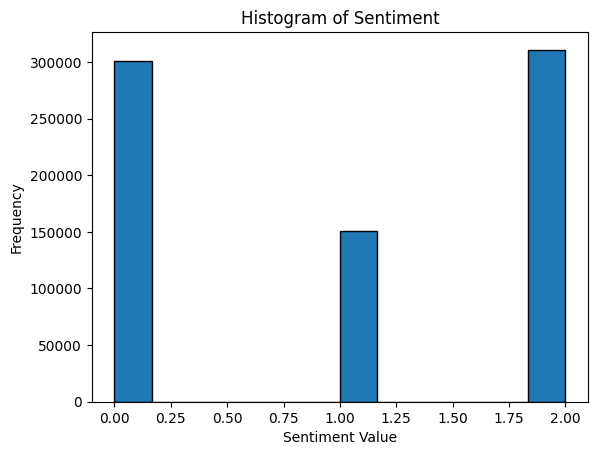

In [ ]:
feature_values = train_dataset['labels']

# Plot the histogram
plt.hist(feature_values, bins=12, edgecolor='black')
plt.title('Histogram of Sentiment')
plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
train_dataset[4]

{'asin': 'B00002QUKW',
 'helpful_vote': 8,
 'parent_asin': 'B0BZ5DSM5V',
 'rating': 3.0,
 'text': 'The Dymo label printers work hard in my office.  They are a little finicky with labels, so I have always purchased DYMO BRAND labels to use with them.<br /><br />THESE ARE NOT DYMO BRAND LABELS.  I believe the product description is intentionally misleading - it should say &#34;Shipping Labels FOR Dymo LabelWriter&#34; etc.<br /><br />I am taking 2 stars off for deceptive product labeling.<br /><br />They seem to work ok (so far), but I am still a bit peeved about being deceived as to the manufacturer.',
 'timestamp': '1399484118000',
 'title': 'NOT DYMO BRAND!!! But seem to work ok',
 'user_id': 'AEZW2L2I65K6B26KMVBAOTVL5DJA',
 'verified_purchase': True,
 'category': 'Office_Products',
 'has_image': False,
 'labels': 1}

In [ ]:
from google.colab import userdata
import os

# Retrieve the Hugging Face token from Colab secrets
hf_token = userdata.get('HF_TOKEN')

# Set the Hugging Face token as an environment variable
os.environ["HF_TOKEN"] = hf_token

In [ ]:
# Remove null values in text
train_dataset = train_dataset.filter(lambda example: pd.notna(example['text']))
test_dataset = test_dataset.filter(lambda example: pd.notna(example['text']))

Filter:   0%|          | 0/762243 [00:00<?, ? examples/s]

Filter:   0%|          | 0/190561 [00:00<?, ? examples/s]

In [ ]:
# Remove non-string values in text
train_dataset = train_dataset.map(lambda example: {'text': str(example['text'])})
test_dataset = test_dataset.map(lambda example: {'text': str(example['text'])})

Map:   0%|          | 0/761411 [00:00<?, ? examples/s]

Map:   0%|          | 0/190358 [00:00<?, ? examples/s]

In [ ]:
# Remove empty values in text
train_dataset = train_dataset.filter(lambda example: len(example['text'].strip()) > 0)
test_dataset = test_dataset.filter(lambda example: len(example['text'].strip()) > 0)

Filter:   0%|          | 0/761411 [00:00<?, ? examples/s]

Filter:   0%|          | 0/190358 [00:00<?, ? examples/s]

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=8)
test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=8)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=8):   0%|          | 0/761411 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/190358 [00:00<?, ? examples/s]

In [ ]:
# Use this if you need to have a smaller training and testing set. Don't forget to update the input variable of tariner class

# small_train_dataset = train_dataset.shuffle(seed=42).select([i for i in list(range(400000))])
# small_test_dataset = test_dataset.shuffle(seed=42).select([i for i in list(range(10000))])

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import evaluate

# Load multiple metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=torch.tensor(labels))
    f1 = f1_metric.compute(predictions=predictions, references=torch.tensor(labels), average="weighted")
    precision = precision_metric.compute(predictions=predictions, references=torch.tensor(labels), average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=torch.tensor(labels), average="weighted")

    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"]
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Finetune the DistilBert Model for the First Time and Save it

In [ ]:
trainer.train()
eval_results = trainer.evaluate()
print(eval_results)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.521000,0.519173,0.783339,0.763184,0.763035,0.783339
2,0.525700,0.510648,0.785965,0.780817,0.778007,0.785965


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.521000,0.519173,0.783339,0.763184,0.763035,0.783339
2,0.525700,0.510648,0.785965,0.780817,0.778007,0.785965
3,0.401300,0.537731,0.783985,0.778913,0.776007,0.783985


{'eval_loss': 0.5106484293937683, 'eval_accuracy': 0.7859653177976118, 'eval_f1': 0.7808169231981029, 'eval_precision': 0.778007146406179, 'eval_recall': 0.7859653177976118, 'eval_runtime': 739.9414, 'eval_samples_per_second': 257.26, 'eval_steps_per_second': 2.573, 'epoch': 3.0}


In [ ]:
model_save_path = "/content/drive/MyDrive/sentiment-model/distilbert-sentiment-model-761K-v1"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
model.config.save_pretrained(model_save_path)

# Install Pre-trained Finetuned DistilBert Model for Re-evaluating

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = "/content/drive/MyDrive/sentiment-model/distilbert-sentiment-model-761K-v1"
model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)

# Class Level Accuracy Metrics Analysis

In [ ]:
# Evaluate the model
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

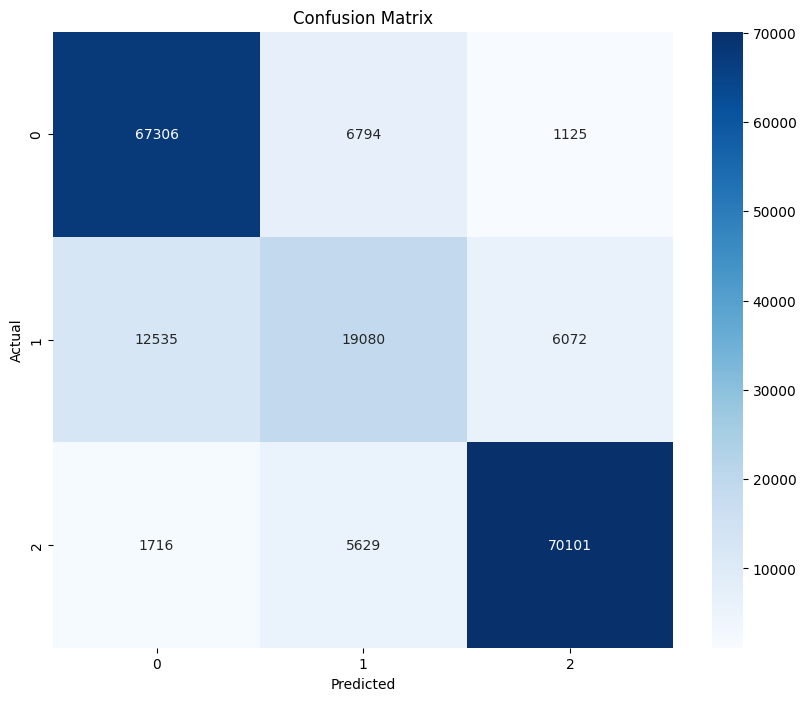

Per-class Metrics:

Negative:
Precision: 0.83
Recall: 0.89
F1-score: 0.86

Neutral:
Precision: 0.61
Recall: 0.51
F1-score: 0.55

Positive:
Precision: 0.91
Recall: 0.91
F1-score: 0.91

Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.89      0.86     75225
     Neutral       0.61      0.51      0.55     37687
    Positive       0.91      0.91      0.91     77446

    accuracy                           0.82    190358
   macro avg       0.78      0.77      0.77    190358
weighted avg       0.81      0.82      0.82    190358



In [ ]:
# Generate confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate per-class metrics
class_names = ['Negative', 'Neutral', 'Positive']
print("Per-class Metrics:")
for i, class_name in enumerate(class_names):
    true_positive = cm[i, i]
    false_positive = cm[:, i].sum() - true_positive
    false_negative = cm[i, :].sum() - true_positive

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{class_name}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=class_names))

In [ ]:
from google.colab import runtime
runtime.unassign()